In [1]:
import sys
sys.path.append("C:/Users/timlf/PycharmProjects/Semester_Project_Too/LIFE-Retrieval-Framework/pyretlife/retrieval_plotting/")

from run_plotting import retrieval_plotting_object



problem: Could not find module 'libmultinest.dll' (or one of its dependencies). Try using the full path with constructor syntax.


SystemExit: 1

C:\Users\timlf\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\core\interactiveshell.py:3707: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [1]:
import os
print(os.environ.get("PATH"))

C:\Users\timlf\PycharmProjects\Semester_Project_Too\.venv\Scripts;C:\WINDOWS\system32;C:\WINDOWS;C:\WINDOWS\System32\Wbem;C:\WINDOWS\System32\WindowsPowerShell\v1.0\;C:\WINDOWS\System32\OpenSSH\;C:\Program Files\ffmpeg-7.1-essentials_build\bin;C:\TDM-GCC-64\bin;C:\Program Files\Git\cmd;C:\Users\timlf\AppData\Local\Programs\Python\Launcher\;C:\Users\timlf\AppData\Local\Microsoft\WindowsApps;C:\Users\timlf\AppData\Roaming\Programs\Zero Install;C:\Users\timlf\AppData\Local\GitHubDesktop\bin;C:\msys64\mingw64\bin;


In [1]:
import sys, platform
print("Python executable:", sys.executable)
print("Platform:", platform.system())

Python executable: /home/timlf/myenv/bin/python
Platform: Linux


In [106]:
import pyretlife
print(pyretlife.__file__)

/home/timlf/software/pyRetLIFE/pyretlife/__init__.py


In [1]:
from argparse import ArgumentParser, Namespace
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
from scipy.ndimage import gaussian_filter

from pyretlife.retrieval_plotting.run_plotting import retrieval_plotting_object
from pyretlife.retrieval_plotting.posterior_plotting import (
    Generate_Parameter_Titles,
    Scale_Posteriors
)

In [2]:
def copy_spectrum(directory):
    matches = [
        f for f in glob.glob(os.path.join(directory, "input_*.txt"))
        if os.path.basename(f) != "input_spectrum.txt"]
    if matches:
        source = matches[0]
        destination = os.path.join(directory, "input_spectrum.txt")
        shutil.copy(source, destination)

def load_data(
        self,
        log_pressures=True,
        log_mass=True,
        log_abundances=True,
        log_particle_radii=True,
        plot_pt=True,
        plot_physparam=True,
        plot_clouds=True,
        plot_chemcomp=True,
        plot_scatt=True,
        plot_moon=False,
        plot_secondary_parameters=True,
        parameter_units='input',
        custom_unit_titles={},
        custom_parameter_titles={}
):
    """
    Loads and returns the data for the retrieved parameters as well as the upper-log-uniform (ULU), the truth values and the parameter names.

    Parameters
    ----------
    log_pressures :  bool, optional
        If True, applies a logarithmic scale to pressure values. Defaults to True.

    log_mass : bool, optional
        If True, applies a logarithmic scale to mass values. Defaults to True.

    log_abundances :  bool, optional
        If True, applies a logarithmic scale to abundance values. Defaults to True.

    log_particle_radii : bool, optional
        If True, applies a logarithmic scale to particle radii values. Defaults to True.

    plot_pt :  bool, optional
        If True, plots pressure-temperature parameters. Defaults to True.

    plot_physparam : bool, optional
        If True, plots physical parameters. Defaults to True.

    plot_clouds :  bool, optional
        If True, plots cloud parameters. Defaults to True.

    plot_chemcomp : bool, optional
        If True, plots chemical composition parameters. Defaults to True.

    plot_scatt : bool, optional
        If True, plots scattering parameters. Defaults to True.

    plot_moon :  bool, optional
        If True, plots moon parameters. Defaults to False.

    plot_secondary_parameters : bool, optional
        If True, plots secondary parameters. Defaults to True.

    parameter_units : str, optional
        The units to use for plotting. Defaults to 'input', which are the units specified in the config file.

    custom_unit_titles : dict, optional
        A dictionary mapping parameters to custom unit titles. Defaults to an empty dictionary.

    custom_parameter_titles={} : dict, optional
        A dictionary mapping parameters to custom titles. Defaults to an empty dictionary.
    """

    recompute = False
    self.calculate_posterior_spectrum(reevaluate_spectra=False)
    if np.shape(self.retrieved_fluxes)[0] != np.shape(self.posteriors)[0]:
        print('reevaluating spectrum due to dimension error.')
        delattr(self, 'retrieved_fluxes')
        self.calculate_posterior_spectrum(reevaluate_spectra=True)
        recompute = True
        # copy_spectrum(self.results_directory)

    try:
        self.calculate_posterior_pt_profile(n_processes=4,reevaluate_PT=recompute)

        self.deduce_bond_albedo(stellar_luminosity=1.0,
                            	error_stellar_luminosity=0.01,
                            	planet_star_separation=1.0,
                        		error_planet_star_separation=0.01,
                        		true_equilibrium_temperature = 255,
                        		true_bond_albedo = 0.29,
                        		reevaluate_bond_albedo=recompute)
        self.deduce_abundance_profiles(reevaluate_abundance_profiles=recompute)

        self.deduce_gravity(true_gravity = 981)
        self.deduce_surface_temperature(true_surface_temperature = 273)

    except Exception as e:
        print(f"Error correcting data for {self.results_directory}: {e}")
        return None, None, None, None


    parameters_plotted = []
    for parameter in self.parameters:
        if (self.parameters[parameter]['type'] == 'TEMPERATURE PARAMETERS') and plot_pt:
            parameters_plotted += [parameter]
        elif (self.parameters[parameter]['type'] == 'PHYSICAL PARAMETERS') and plot_physparam:
            parameters_plotted += [parameter]
        elif (self.parameters[parameter]['type'] == 'CHEMICAL COMPOSITION PARAMETERS') and plot_chemcomp:
            parameters_plotted += [parameter]
        elif (self.parameters[parameter]['type'] == 'CLOUD PARAMETERS') and plot_clouds:
            parameters_plotted += [parameter]
        elif (self.parameters[parameter]['type'] == 'SCATTERING PARAMETERS') and plot_scatt:
            parameters_plotted += [parameter]
        elif (self.parameters[parameter]['type'] == 'SECONDARY PARAMETERS') and plot_secondary_parameters:
            parameters_plotted += [parameter]
        elif (self.parameters[parameter]['type'] == 'MOON PARAMETERS') and plot_moon:
            parameters_plotted += [parameter]

    local_post = self.posteriors.copy()
    local_truths = {parameter:self.parameters[parameter]['truth'] for parameter in parameters_plotted}

    Generate_Parameter_Titles(self)
    local_titles = {i:self.parameters[i]['title'] for i in parameters_plotted}
    for parameter in parameters_plotted:
        if parameter in custom_parameter_titles:
            local_titles[parameter] = custom_parameter_titles[parameter]

    retrieval_unit =  {i:self.parameters[i]['unit'] for i in parameters_plotted}
    if parameter_units == 'input':
        local_units = {i:self.parameters[i]['input_unit'] for i in parameters_plotted}
    else:
        local_units = retrieval_unit.copy()
        for parameter in parameters_plotted:
            if parameter in parameter_units:
                local_units[parameter] = parameter_units[parameter]

    for parameter in parameters_plotted:
        if not f"{local_units[parameter]:latex}" == '$\\mathrm{}$':
            unit = '\\left['+f"{local_units[parameter]:latex}"[1:-1]+'\\right]'
        else:
            unit = ''
        if parameter in custom_unit_titles:
            unit = '\\left['+custom_unit_titles[parameter][1:-1]+'\\right]'
        local_titles[parameter] = local_titles[parameter][:-1]+unit+'$'

    for parameter in parameters_plotted:
        local_post[parameter] = self.units.truth_unit_conversion(parameter,retrieval_unit[parameter],local_units[parameter],local_post[parameter].to_numpy(),printing=False)
        local_truths[parameter] = self.units.truth_unit_conversion(parameter,retrieval_unit[parameter],local_units[parameter],local_truths[parameter],printing=False)

    local_post, local_truths, local_titles = Scale_Posteriors(self,local_post, local_truths, local_titles, parameters_plotted,
                                                              log_pressures=log_pressures, log_mass=log_mass,
                                                              log_abundances=log_abundances, log_particle_radii=log_particle_radii)

    dataset = {}
    for param in parameters_plotted:
        dataset[param] = local_post[param]

    return dataset, local_truths, parameters_plotted

In [3]:
from pyretlife.retrieval_plotting.run_plotting import retrieval_plotting_object
retrieval_plotting_object.load_data = load_data

def plot_retrievals(
        labels,
        folders,
        colors=None,
        params_to_plot=None,
        bins=50,
        fig_title=None,
        output='retrieval_comparison.pdf',
):
    """
    Plot the histogram for a series of retrievals.

    Parameters
    ----------
    labels : dict
        Dictionary mapping run names to legend labels.

    folders : dict
        Dictionary mapping run names to folder with the run data.

    colors : dict, optional
        Dictionary mapping run names to histogram colors. Default is a generic color palette with 10 unique options.

    params_to_plot : list, optional
        List of parameter names to plot. Default is all.

    bins : int or sequence, optional
        Number of histogram bins (default 50).

    fig_title : str, optional
        Title for the whole figure.

    output : str, optional
        name of the output path. Default is 'retrieval_comparison.pdf'.
    """

    datasets = {}
    local_truths = []
    params = []
    for label in labels.keys():
        results = retrieval_plotting_object(folders[label], run_retrieval=False)
        ds, lt, pa = results.load_data()
        if ds is not None:
            datasets[label], local_truths, params = ds, lt, pa

    if not datasets:
        print("No datasets could be loaded.")
        return

    n_params = len(params)
    n_cols = 4
    n_rows = int(np.ceil(n_params / n_cols))

    fig, axs = plt.subplots(
        n_rows, n_cols,
        figsize=(4.5 * n_cols, 3 * n_rows),
        constrained_layout=False
    )
    axs = axs.flatten()

    if colors is None:
        default_colors = [
            "mediumpurple", "indianred", "goldenrod", "steelblue", "darkorange", "seagreen", "firebrick", "royalblue", "darkkhaki"
        ]
        colors = {label: default_colors[i % len(default_colors)] for i, label in enumerate(datasets.keys())}

    for i, param in enumerate(params):
        if params_to_plot is not None and param not in params_to_plot:
            continue

        ax = axs[i]

        for run_name, data in datasets.items():
            if param in data.keys():
                h = ax.hist(
                    data[param],
                    histtype='stepfilled',
                    color=colors.get(run_name, 'gray'),
                    alpha=0.5,
                    linewidth=5,
                    density=True,
                    bins=bins,
                    label=labels.get(run_name, run_name)
                )

        ax.set_title(param, fontsize=12)
        ax.set_ylabel("Prob. density")
        ax.tick_params(labelsize=10)
        ax.grid(False)

        ax.axvline(local_truths[param], color='k', linestyle='--', linewidth=1.5)

    # Hide unused subplots
    for j in range(i + 1, len(axs)):
        axs[j].axis('off')

    fig.subplots_adjust(top=0.90, bottom=0.08, left=0.07, right=0.98, hspace=0.35, wspace=0.25)

    if fig_title:
        fig.suptitle(fig_title, fontsize=16, weight='bold', y=0.965)

    # Create a single legend above all plots
    handles, legend_labels = axs[0].get_legend_handles_labels()
    fig.legend(
        handles,
        legend_labels,
        loc='upper center',
        bbox_to_anchor=(0.5, 0.935),
        ncol=len(datasets),
        fontsize=11,
        frameon=False
    )
    plt.savefig(output)
    plt.show()

Conversion performed for truth value of d_syst.
Input value: 10.0 pRT_pc
Converted value: 3.085677581491368e+17 m

Conversion performed for truth value of M_pl.
Input value: 1.0 pRT_M_earth
Converted value: 5.972167867791379e+27 g

Conversion performed for truth value of R_pl.
Input value: 1.0 pRT_R_earth
Converted value: 637810000.0 cm

Conversion performed for prior of R_pl. Prior kind: gaussian
Input values: {'mean': 1, 'sigma': 0.2} pRT_R_earth
Converted value: {'mean': 637810000.0, 'sigma': 127562000.0} cm

Nautilus output not found, trying MultiNest...
  analysing data from /mnt/d/timlf/Tim Daten/Desktop/Testrun/results/Retrieval1_known/.txt
Loaded previously calculated spectra from /mnt/d/timlf/Tim Daten/Desktop/Testrun/results/Retrieval1_known/Plots_New/Ret_Spec_Skip_1.pkl.

Loaded previously calculated PT profiles from /mnt/d/timlf/Tim Daten/Desktop/Testrun/results/Retrieval1_known/Plots_New/Ret_PT_Skip_1.pkl.

Loaded previously calculated Bond albedos from /mnt/d/timlf/Tim Da

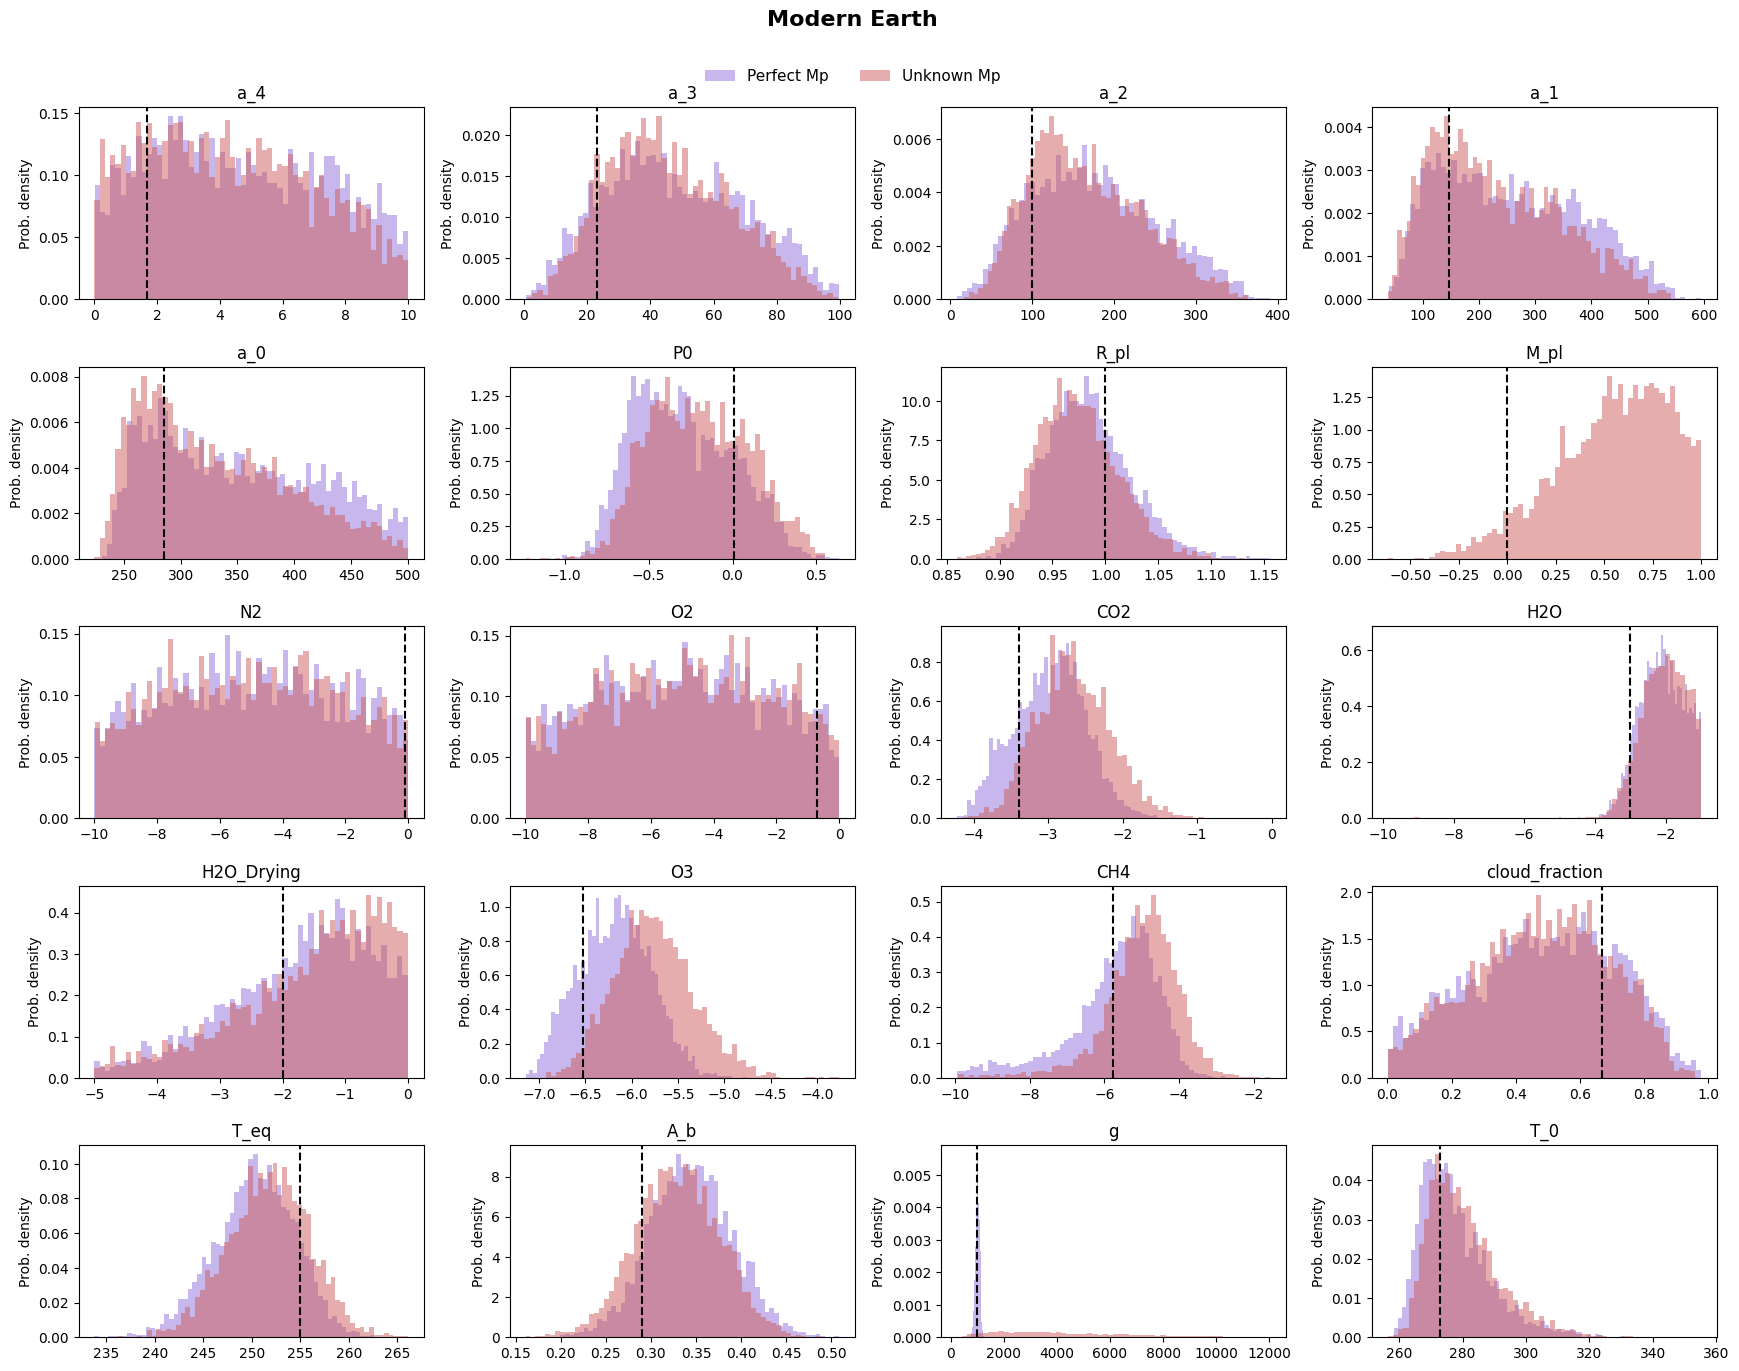

In [16]:
labels = {
    "Perfect Mp": "Perfect Mp",
    "Unknown Mp": "Unknown Mp",
    # "Gaussian 10": "Gaussian prior (10%)",
    # "Loggauss 4": "Log-Gaussian prior (0.4)",
    # "Loggauss 6": "Log-Gaussian prior (0.6)",
}

folders = {
    "Perfect Mp": '/mnt/d/timlf/Tim Daten/Desktop/Testrun/results/Retrieval1_known/',
    "Unknown Mp": '/mnt/d/timlf/Tim Daten/Desktop/Earthlike_Retrieval/results/Retrieval2_uniform/',
    # "Gaussian 10": '/mnt/d/timlf/Tim Daten/Desktop/Earthlike_Retrieval/results/VH2O_CL_gauss10/',
    # "Loggauss 4": '/mnt/d/timlf/Tim Daten/Desktop/Earthlike_Retrieval/results/VH2O_CL_log04/',
    # "Loggauss 6": '/mnt/d/timlf/Tim Daten/Desktop/Earthlike_Retrieval/results/VH2O_CL_log06/',
}

plot_retrievals(labels, folders, bins=60, fig_title="Modern Earth")

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from pyretlife.retrieval_plotting.posterior_plotting import (
    Generate_Parameter_Titles,
    Scale_Posteriors,
)

labels = {
    "Perfect Mp": "Perfect Mp",
    "Unknown Mp": "Unknown Mp",
    # "Gaussian 10": "Gaussian prior (10%)",
    # "Loggauss 4": "Log-Gaussian prior (0.4)",
    # "Loggauss 6": "Log-Gaussian prior (0.6)",
}

folders = {
    "Perfect Mp": '/mnt/d/timlf/Tim Daten/Desktop/Testrun/results/Retrieval1_known/',
    "Unknown Mp": '/mnt/d/timlf/Tim Daten/Desktop/Earthlike_Retrieval/results/Retrieval2_uniform/',
    # "Gaussian 10": '/mnt/d/timlf/Tim Daten/Desktop/Earthlike_Retrieval/results/VH2O_CL_gauss10/',
    # "Loggauss 4": '/mnt/d/timlf/Tim Daten/Desktop/Earthlike_Retrieval/results/VH2O_CL_log04/',
    # "Loggauss 6": '/mnt/d/timlf/Tim Daten/Desktop/Earthlike_Retrieval/results/VH2O_CL_log06/',
}
retrieval_plotting_object.load_data = load_data

datasets = {}
local_truths = []
params = []
for label in labels.keys():
    results = retrieval_plotting_object(folders[label])
    ds, lt, pa = results.load_data()
    if ds is not None:
        datasets[label], local_truths, params = ds, lt, pa

Conversion performed for truth value of d_syst.
Input value: 10.0 pRT_pc
Converted value: 3.085677581491368e+17 m

Conversion performed for truth value of M_pl.
Input value: 1.0 pRT_M_earth
Converted value: 5.972167867791379e+27 g

Conversion performed for truth value of R_pl.
Input value: 1.0 pRT_R_earth
Converted value: 637810000.0 cm

Conversion performed for prior of R_pl. Prior kind: gaussian
Input values: {'mean': 1, 'sigma': 0.2} pRT_R_earth
Converted value: {'mean': 637810000.0, 'sigma': 127562000.0} cm

Nautilus output not found, trying MultiNest...
  analysing data from /mnt/d/timlf/Tim Daten/Desktop/Testrun/results/Retrieval1_known/.txt
Loaded previously calculated spectra from /mnt/d/timlf/Tim Daten/Desktop/Testrun/results/Retrieval1_known/Plots_New/Ret_Spec_Skip_1.pkl.

Loaded previously calculated PT profiles from /mnt/d/timlf/Tim Daten/Desktop/Testrun/results/Retrieval1_known/Plots_New/Ret_PT_Skip_1.pkl.

Loaded previously calculated Bond albedos from /mnt/d/timlf/Tim Da

In [59]:
def plot_comparison_intervals(
        labels,
        folders,
        colors=None,
        params_to_plot=None,
        figsize=(16, 16),
        n_cols=4,
        quantiles=(0.16, 0.5, 0.84),
        truth_band_width=0,
        fig_title=None,
        savepath=None,
):
    """
    Create stacked horizontal-interval comparison plots for multiple retrievals.

    Parameters
    ----------
    labels : dict
        Dictionary mapping run names to legend labels.

    folders : dict
        Dictionary mapping run names to folder with the run data.

    colors : dict, optional
        Dictionary mapping run names to histogram colors. Default is a generic color palette with 10 unique options.

    params_to_plot : list, optional
        List of parameter names to plot. Default is all.

    figsize : tuple, optional
        Size of figure in inches. Default is (16, 16).

    n_cols : int, optional
        Number of subplots in each row. Default is 4.

    quantiles : tuple, optional
        q value for which np.quantile computes the q-th percentile of the data along the specified axis.

    truth_band_width : float, optional
        Width of band to use for comparison. Default is no band.

    fig_title : str, optional
        Title for the whole figure.

    savepath : str, optional
        Saves the figure at the given filepath. When no path is provided the figure is not saved.
    """

    retrieval_plotting_object.load_data = load_data

    # datasets = {}
    # local_truths = []
    # params = []
    # for label in labels.keys():
    #     results = retrieval_plotting_object(folders[label])
    #     ds, lt, pa = results.load_data()
    #     if ds is not None:
    #         datasets[label], local_truths, params = ds, lt, pa

    n_params = len(params)

    # Colors
    if colors is None:
        default = ['firebrick', 'royalblue', 'goldenrod','forestgreen', 'darkviolet',  'darkorange']
        colors = {lab: default[i % len(default)] for i, lab in enumerate(labels.keys())}

    n_rows = int(np.ceil(n_params / n_cols))
    fig, axs = plt.subplots(
        n_rows, n_cols,
        figsize=figsize,
        constrained_layout=False
    )
    axs = axs.flatten()

    for i, param in enumerate(params):
        if params_to_plot is not None and param not in params_to_plot:
            continue

        ax = axs[i]

        # Shaded truth band
        t = local_truths[param]
        ax.axvspan(t * (1 - truth_band_width), t * (1 + truth_band_width),
                   color="lightgray", alpha=0.5, zorder=0)

        ax.axvline(x=t, color='gray', linestyle='--', linewidth=1.5, zorder=0)

        # Horizontal category positions
        y_positions = np.arange(len(labels))

        for j, run in enumerate(labels.keys()):

            if param not in datasets[run]:
                continue

            samples = np.asarray(datasets[run][param])
            q_low, q_med, q_high = np.quantile(samples, quantiles)

            # Main interval line
            ax.hlines(
                y_positions[j],
                q_low, q_high,
                color=colors[run],
                linewidth=2
            )

            # Arrows at interval edges
            ax.plot(q_low,  y_positions[j], marker='|', color=colors[run], ms=8)
            ax.plot(q_high, y_positions[j], marker='|', color=colors[run], ms=8)

            # Median marker
            ax.plot(q_med,  y_positions[j], marker='o', color=colors[run], ms=6)

        if i % n_cols == 0:
            ax.set_yticks(y_positions)
            ax.set_yticklabels(labels.values(), fontsize=11)
        else:
            ax.set_yticklabels([])
            ax.set_yticks([])
        # ax.set_yticks(y_positions)
        # ax.set_yticklabels(labels.values())
        ax.set_ylim(-0.25, len(labels) - 0.75)
        ax.invert_yaxis()
        ax.set_title(param, fontsize=12, weight="bold", pad=3.5)
        ax.grid(False)

    # Remove unused subplots
    for k in range(len(params), len(axs)):
        axs[k].axis("off")

    if fig_title:
        fig.suptitle(fig_title, fontsize=20, weight='bold', y=0.92)

    wspace = 0.015 * max(len(la) for la in labels.values()) + 0.04
    fig.subplots_adjust(hspace=0.3, wspace=0.01)

    if savepath is not None:
        plt.savefig(savepath, dpi=200, bbox_inches="tight")

    plt.show()

Conversion performed for truth value of d_syst.
Input value: 10.0 pRT_pc
Converted value: 3.085677581491368e+17 m

Conversion performed for truth value of M_pl.
Input value: 1.0 pRT_M_earth
Converted value: 5.972167867791379e+27 g

Conversion performed for truth value of R_pl.
Input value: 1.0 pRT_R_earth
Converted value: 637810000.0 cm

Conversion performed for prior of R_pl. Prior kind: gaussian
Input values: {'mean': 1, 'sigma': 0.2} pRT_R_earth
Converted value: {'mean': 637810000.0, 'sigma': 127562000.0} cm

Nautilus output not found, trying MultiNest...
  analysing data from /mnt/d/timlf/Tim Daten/Desktop/Testrun/results/Retrieval1_known/.txt
Loaded previously calculated spectra from /mnt/d/timlf/Tim Daten/Desktop/Testrun/results/Retrieval1_known/Plots_New/Ret_Spec_Skip_1.pkl.

Loaded previously calculated PT profiles from /mnt/d/timlf/Tim Daten/Desktop/Testrun/results/Retrieval1_known/Plots_New/Ret_PT_Skip_1.pkl.

Loaded previously calculated Bond albedos from /mnt/d/timlf/Tim Da

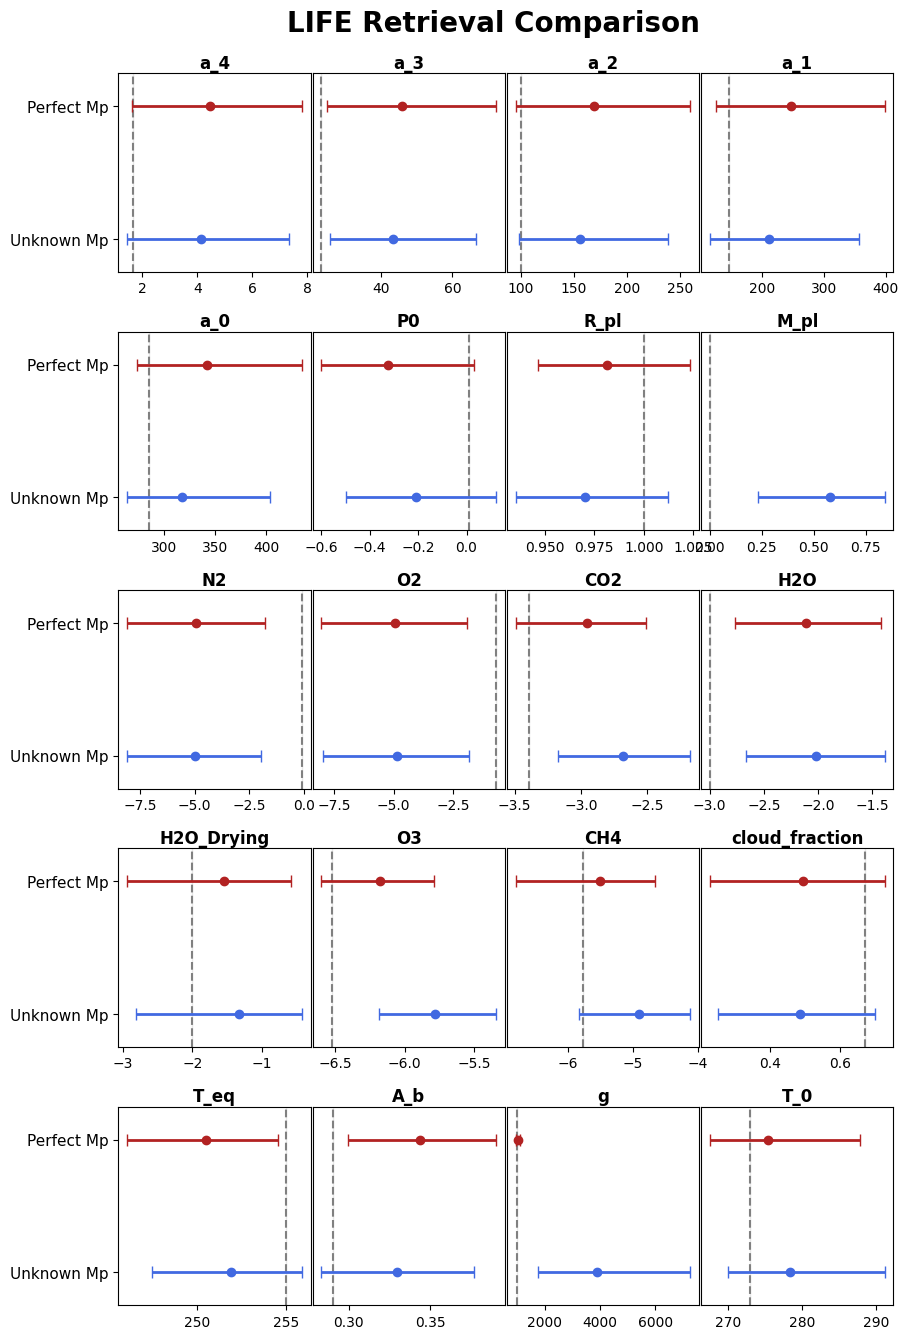

In [62]:
# from helper_functions import plot_retrievals
from pyretlife.retrieval_plotting.run_plotting import retrieval_plotting_object
from pyretlife.retrieval_plotting.posterior_plotting import (
    Generate_Parameter_Titles,
    Scale_Posteriors
)
labels = {
    "Perfect Mp": "Perfect Mp",
    # "Perfect Mp": "Log-Gaussian prior (0.5)",
    "Unknown Mp": "Unknown Mp",
    # "Gaussian 10": "Gaussian prior (10%)",
    # "Loggauss 4": "Log-Gaussian prior (0.4)",
    # "Loggauss 6": "Log-Gaussian prior (0.6)",
}

folders = {
    "Perfect Mp": '/mnt/d/timlf/Tim Daten/Desktop/Testrun/results/Retrieval1_known/',
    "Unknown Mp": '/mnt/d/timlf/Tim Daten/Desktop/Earthlike_Retrieval/results/Retrieval2_uniform/',
    # "Gaussian 10": '/mnt/d/timlf/Tim Daten/Desktop/Earthlike_Retrieval/results/VH2O_CL_gauss10/',
    # "Loggauss 4": '/mnt/d/timlf/Tim Daten/Desktop/Earthlike_Retrieval/results/VH2O_CL_log04/',
    # "Loggauss 6": '/mnt/d/timlf/Tim Daten/Desktop/Earthlike_Retrieval/results/VH2O_CL_log06/',
}
retrieval_plotting_object.load_data = load_data

datasets = {}
local_truths = []
params = []
for label in labels.keys():
    results = retrieval_plotting_object(folders[label])
    ds, lt, pa = results.load_data()
    if ds is not None:
        datasets[label], local_truths, params = ds, lt, pa

plot_comparison_intervals(labels, folders, figsize=(10,16), fig_title='LIFE Retrieval Comparison', savepath=None)

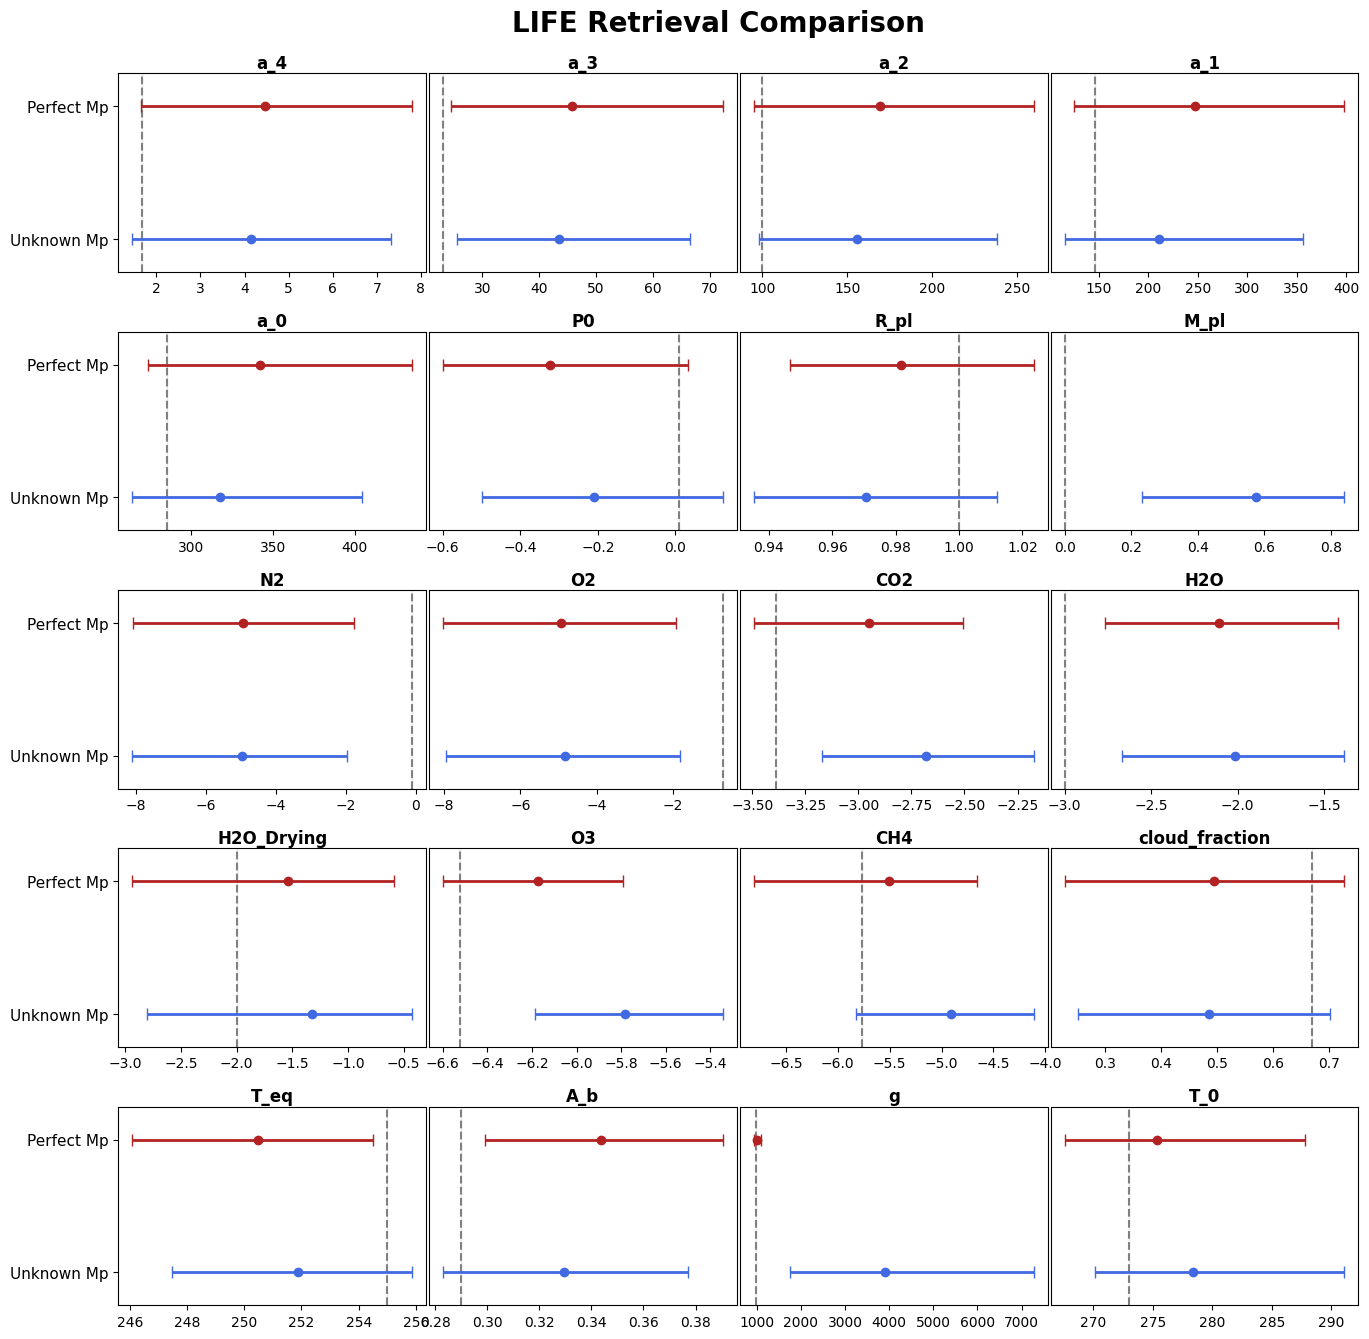

In [65]:
plot_comparison_intervals(labels, folders, figsize=(16,16), fig_title='LIFE Retrieval Comparison', savepath=None)

In [107]:
from pyretlife.retrieval_plotting.run_plotting import retrieval_plotting_object

result = retrieval_plotting_object('/mnt/d/timlf/Tim Daten/Desktop/Testrun/results/Retrieval1_known/')

Conversion performed for truth value of d_syst.
Input value: 10.0 pRT_pc
Converted value: 3.085677581491368e+17 m

Conversion performed for truth value of M_pl.
Input value: 1.0 pRT_M_earth
Converted value: 5.972167867791379e+27 g

Conversion performed for truth value of R_pl.
Input value: 1.0 pRT_R_earth
Converted value: 637810000.0 cm

Conversion performed for prior of R_pl. Prior kind: gaussian
Input values: {'mean': 1, 'sigma': 0.2} pRT_R_earth
Converted value: {'mean': 637810000.0, 'sigma': 127562000.0} cm

Nautilus output not found, trying MultiNest...
  analysing data from /mnt/d/timlf/Tim Daten/Desktop/Testrun/results/Retrieval1_known/.txt


In [109]:
result.parameters

{'a_4': {'input_unit': Unit(dimensionless),
  'unit': Unit(dimensionless),
  'input_truth': 1.67,
  'truth': 1.67,
  'prior': {'kind': 'uniform',
   'prior_specs': {'lower': 0.0, 'upper': 10.0},
   'input_prior_specs': {'lower': 0, 'upper': 10}},
  'type': 'TEMPERATURE PARAMETERS'},
 'a_3': {'input_unit': Unit(dimensionless),
  'unit': Unit(dimensionless),
  'input_truth': 23.12,
  'truth': 23.12,
  'prior': {'kind': 'uniform',
   'prior_specs': {'lower': 0.0, 'upper': 100.0},
   'input_prior_specs': {'lower': 0.0, 'upper': 100.0}},
  'type': 'TEMPERATURE PARAMETERS'},
 'a_2': {'input_unit': Unit(dimensionless),
  'unit': Unit(dimensionless),
  'input_truth': 99.7,
  'truth': 99.7,
  'prior': {'kind': 'uniform',
   'prior_specs': {'lower': 0.0, 'upper': 500.0},
   'input_prior_specs': {'lower': 0.0, 'upper': 500.0}},
  'type': 'TEMPERATURE PARAMETERS'},
 'a_1': {'input_unit': Unit(dimensionless),
  'unit': Unit(dimensionless),
  'input_truth': 146.63,
  'truth': 146.63,
  'prior': {'ki

In [35]:
from scipy.interpolate import PchipInterpolator
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, FixedLocator, LogLocator, ScalarFormatter
R_earth = 637810000.0
M_earth = 5.972167867791379e+27
masses = np.array([0.125,0.25,0.5,1.0,2.0,4.0,8.0,16.0,32.0])
R100Fe =  np.array([0.445,0.55,0.676,0.823,0.99,1.176,1.38,1.59,1.82])
R100H2O = np.array([0.776,0.952,1.163,1.41,1.71,2.05,2.45,2.9,3.36])
lowerf = PchipInterpolator(masses, R100Fe)
upperf = PchipInterpolator(masses, R100H2O)

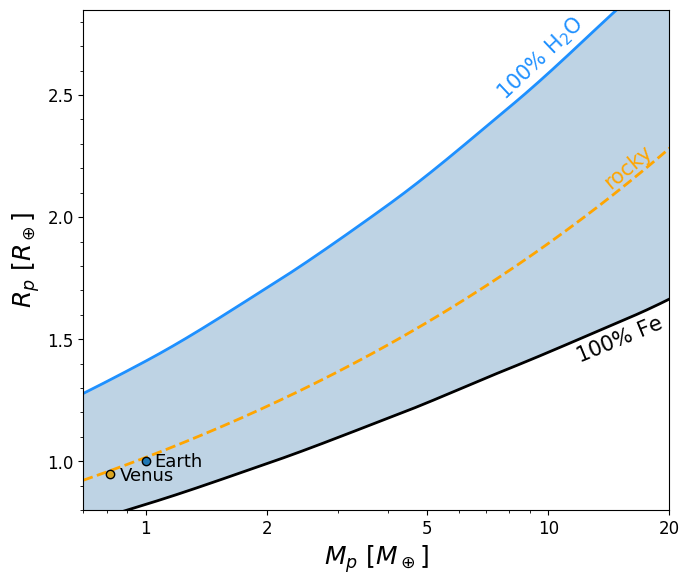

In [148]:
M = np.logspace(-1.3,1.31, 400)  # 0.06–100 Earth masses

# Example power-law relations (replace with your own)
R_low = lowerf(M)
R_high = upperf(M)
R_ref = 1.0154 * M**(1/3.7)

fig, ax = plt.subplots(figsize=(7, 6))

# Shaded composition band
ax.fill_between(
    M,
    R_low,
    R_high,
    color="steelblue",
    alpha=0.35,
    zorder=1
)

# Boundary curves
ax.plot(M, R_low, color="black", lw=2, label="Lower density bound")
ax.plot(M, R_high, color="dodgerblue", lw=2, label="Upper density bound")

# Optional reference curve
if R_ref is not None:
    ax.plot(
        M,
        R_ref,
        color="orange",
        ls="--",
        lw=2,
        label="Reference density"
    )

# Axes styling
ax.set_xscale("log")
ax.set_xlabel(r"$M_p\ [M_\oplus]$", fontsize=18, fontweight="bold")
ax.set_ylabel(r"$R_p\ [R_\oplus]$", fontsize=18, fontweight="bold")

# ax.set_xlim(min(M), max(M))
# ax.set_ylim(0.25, 2.2)
ax.set_xlim(0.7, 20)
ax.set_ylim(0.8, 2.85)
ax.yaxis.set_major_locator(MultipleLocator(0.5))
ax.yaxis.set_minor_locator(MultipleLocator(0.1))
ax.set_xscale("log")

ax.xaxis.set_major_locator(LogLocator(base=10, subs=(1, 2, 5)))
ax.xaxis.set_major_formatter(ScalarFormatter())
ax.xaxis.set_minor_locator(LogLocator(base=10, subs=np.arange(1, 10)*0.1))

ax.tick_params(axis="both", labelsize=12)

ax.grid(False)

#Line names
ax.text(
    7.3,
    2.46,
    r"$100\%\  \mathrm{H}_2\mathrm{O}$",
    fontsize=15,
    rotation=43.5,
    ha="left",
    va="bottom",
    color='dodgerblue',
)

ax.text(
    11.5,
    1.39,
    r"$100\%\  \mathrm{Fe}$",
    fontsize=15,
    rotation=22.5,
    ha="left",
    va="bottom",
    color='black',
)

ax.text(
    13.5,
    2.1,
    r"rocky",
    fontsize=15,
    rotation=40,
    ha="left",
    va="bottom",
    color='orange',
)

#Planets
ax.scatter(
    1,
    1,
    color="tab:blue",
    edgecolor="black",
    zorder=5
)
ax.text(
    1 + 0.05,
    1,
    r"Earth",
    fontsize=13,
    ha="left",
    va="center",
    color='black',
)

ax.scatter(
    0.815,
    0.949,
    color="goldenrod",
    edgecolor="black",
    zorder=5
)
ax.text(
    0.815 + 0.05,
    0.949 - 0.01,
    r"Venus",
    fontsize=13,
    ha="left",
    va="center",
    color='black',
)

plt.tight_layout()
plt.savefig("mass_radius.pdf", bbox_inches="tight")

plt.show()


In [24]:
(1.07 - 0.21 * 0.26)

1.0154

In [67]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from pyretlife.retrieval_plotting.posterior_plotting import (
    Generate_Parameter_Titles,
    Scale_Posteriors,
)

labels = {
    "R1": "Perfect 10",
    "R2": "Unknown 10",
    "R3": "Perfect 30",
    "R4": "Unknown 30",
    "R5": "Perfect 50",
    "R6": "Unknown 50",
}

folders = {
    "R1": '/mnt/d/timlf/Tim Daten/Desktop/sn10/results/Retrieval1_known/',
    "R2": '/mnt/d/timlf/Tim Daten/Desktop/sn10/results/Retrieval2_uniform/',
    "R3": '/mnt/d/timlf/Tim Daten/Desktop/sn30/results/Retrieval1_known/',
    "R4": '/mnt/d/timlf/Tim Daten/Desktop/sn30/results/Retrieval2_uniform/',
    "R5": '/mnt/d/timlf/Tim Daten/Desktop/sn50/results/Retrieval1_known/',
    "R6": '/mnt/d/timlf/Tim Daten/Desktop/sn50/results/Retrieval2_uniform/',
}
retrieval_plotting_object.load_data = load_data

datasets = {}
local_truths = []
params = []
for label in labels.keys():
    results = retrieval_plotting_object(folders[label])
    ds, lt, pa = results.load_data()
    if ds is not None:
        datasets[label], local_truths, params = ds, lt, pa

Conversion performed for truth value of d_syst.
Input value: 10.0 pRT_pc
Converted value: 3.085677581491368e+17 m

Conversion performed for truth value of M_pl.
Input value: 1.0 pRT_M_earth
Converted value: 5.972167867791379e+27 g

Conversion performed for truth value of R_pl.
Input value: 1.0 pRT_R_earth
Converted value: 637810000.0 cm

Conversion performed for prior of R_pl. Prior kind: gaussian
Input values: {'mean': 1, 'sigma': 0.2} pRT_R_earth
Converted value: {'mean': 637810000.0, 'sigma': 127562000.0} cm

Nautilus output not found, trying MultiNest...
  analysing data from /mnt/d/timlf/Tim Daten/Desktop/sn10/results/Retrieval1_known/.txt
Loaded previously calculated spectra from /mnt/d/timlf/Tim Daten/Desktop/sn10/results/Retrieval1_known/Plots_New/Ret_Spec_Skip_1.pkl.

Loaded previously calculated PT profiles from /mnt/d/timlf/Tim Daten/Desktop/sn10/results/Retrieval1_known/Plots_New/Ret_PT_Skip_1.pkl.

Loaded previously calculated Bond albedos from /mnt/d/timlf/Tim Daten/Deskt

In [68]:
# --- grouping configuration ---
sn_groups = ['known', 'unknown']
runs_per_group = 3
group_gap = 0.8  # vertical space between SN groups

# group runs by SN
grouped_runs = {
    "known": ['R5', 'R3', 'R1'],
    "unknown": ['R6', 'R4', 'R2'],
}

# flattened run order (sn10 runs, then sn30, then sn50)
ordered_runs = []
y_positions = []
group_centers = {}

y = 0
for sn in sn_groups:
    runs = grouped_runs[sn]
    start_y = y
    for r in runs:
        ordered_runs.append(r)
        y_positions.append(y)
        y += 1
    end_y = y - 1
    group_centers[sn] = 0.5 * (start_y + end_y)
    y += group_gap  # separation between SN groups

y_positions = np.array(y_positions)

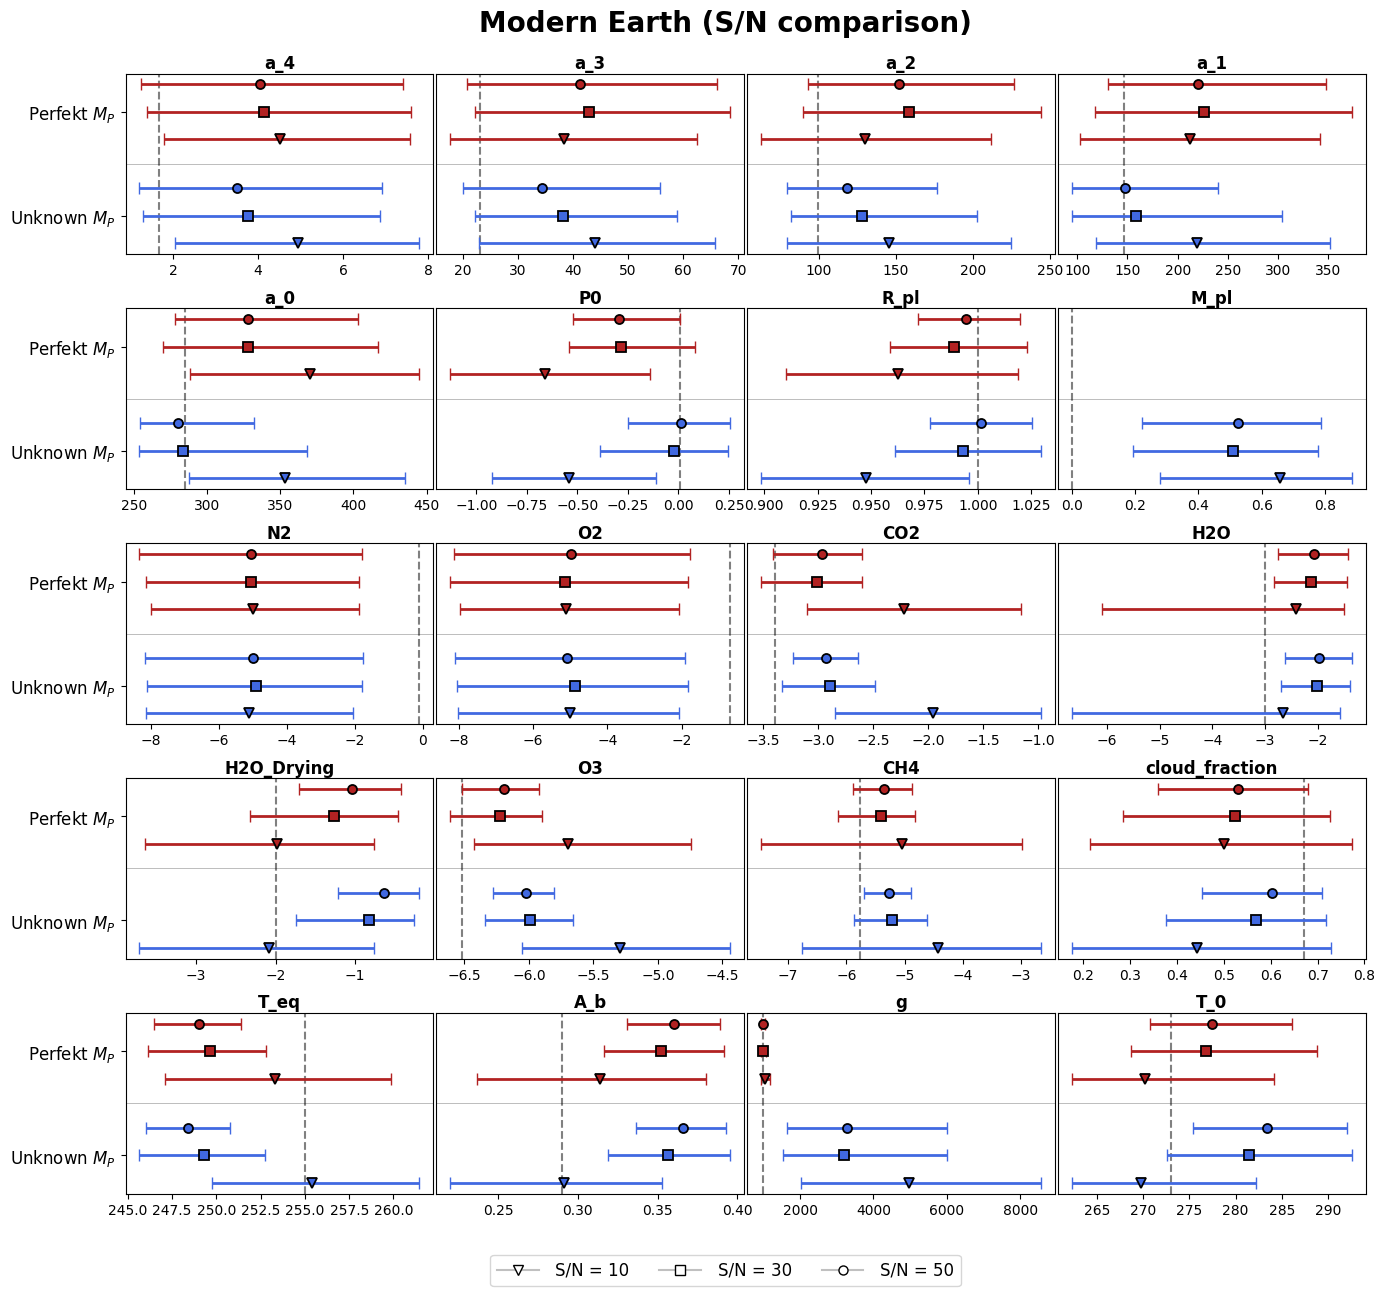

In [103]:
from matplotlib.lines import Line2D
n_params = len(params)
n_cols = 4

c = ['firebrick', 'royalblue']
colors = [c[j//3] for j in range(6)]
# colors = ['firebrick', 'royalblue', 'goldenrod','forestgreen', 'darkviolet',  'darkorange']
markers = ['o', 's', 'v', 'o', 's', 'v']

n_rows = int(np.ceil(n_params / n_cols))
fig, axs = plt.subplots(
    n_rows, n_cols,
    figsize=(16, 16),
    constrained_layout=False
)
axs = axs.flatten()

for i, param in enumerate(params):
    ax = axs[i]

    # Shaded truth band
    t = local_truths[param]
    ax.axvline(x=t, color='gray', linestyle='--', linewidth=1.5, zorder=0)

    # Horizontal category positions
    for j, run in enumerate(ordered_runs):

        if param not in datasets[run]:
            continue

        samples = np.asarray(datasets[run][param])
        q_low, q_med, q_high = np.quantile(samples, (0.16, 0.5, 0.84))

        # Main interval line
        ax.hlines(
            y_positions[j],
            q_low, q_high,
            color=colors[j],
            linewidth=2
        )

        # Arrows at interval edges
        ax.plot(q_low,  y_positions[j], marker='|', color=colors[j], ms=8)
        ax.plot(q_high, y_positions[j], marker='|', color=colors[j], ms=8)

        # Median marker
        ax.plot(
            q_med,
            y_positions[j],
            marker=markers[j],
            linestyle='none',
            markerfacecolor=colors[j],
            markeredgecolor='black',
            markeredgewidth=1.3,
            markersize=6.5
        )

    if i % n_cols == 0:
        ticks = []
        ticklabels = [r'Perfekt $M_P$', r'Unknown $M_P$']

        for sn in sn_groups:
            ticks.append(group_centers[sn])

        ax.set_yticks(ticks)
        ax.set_yticklabels(ticklabels, fontsize=12)
    else:
        ax.set_yticks([])
        ax.set_yticklabels([])
    # ax.set_yticks(y_positions)
    # ax.set_yticklabels(labels.values())
    ax.set_ylim(-0.4, 6.2)
    ax.invert_yaxis()
    ax.set_title(param, fontsize=12, weight="bold", pad=3.5)
    ax.grid(False)


    ax.axhline(np.mean(y_positions), color="black", lw=0.6, alpha=0.3)

# Remove unused subplots
for k in range(len(params), len(axs)):
    axs[k].axis("off")

fig.suptitle('Modern Earth (S/N comparison)', fontsize=20, weight='bold', y=0.92)

wspace = 0.015 * max(len(la) for la in labels.values()) + 0.04
fig.subplots_adjust(hspace=0.3, wspace=0.01)

legend_handles = [
    Line2D([0], [0], marker='v', linestyle='-', color='silver',
           markerfacecolor='white', markeredgecolor='black',
           markersize=6.5, label='S/N = 10'),
    Line2D([0], [0], marker='s', linestyle='-', color='silver',
           markerfacecolor='white', markeredgecolor='black',
           markersize=6.5, label='S/N = 30'),
    Line2D([0], [0], marker='o', linestyle='-', color='silver',
           markerfacecolor='white', markeredgecolor='black',
           markersize=6.5, label='S/N = 50'),
]

fig.legend(
    handles=legend_handles,
    loc='lower center',
    ncol=3,
    frameon=True,
    bbox_to_anchor=(0.5, 0.117),
    fontsize=12,
    handlelength=2.5,
    handletextpad=1.0,
    columnspacing=1.8
)

fig.subplots_adjust(bottom=0.18)


savepath = 'Ret_comparison_sncomp.pdf'
if savepath is not None:
    plt.savefig(savepath, dpi=200, bbox_inches="tight")

plt.show()

In [ ]:
c = ['orangered', 'royalblue','forestgreen', 'darkcyan', 'goldenrod', 'darkviolet']

In [43]:
import math

import matplotlib.pyplot as plt

import matplotlib.colors as mcolors
from matplotlib.patches import Rectangle


def plot_colortable(colors, *, ncols=4, sort_colors=True):

    cell_width = 212
    cell_height = 22
    swatch_width = 48
    margin = 12

    # Sort colors by hue, saturation, value and name.
    if sort_colors is True:
        names = sorted(
            colors, key=lambda c: tuple(mcolors.rgb_to_hsv(mcolors.to_rgb(c))))
    else:
        names = list(colors)

    n = len(names)
    nrows = math.ceil(n / ncols)

    width = cell_width * ncols + 2 * margin
    height = cell_height * nrows + 2 * margin
    dpi = 72

    fig, ax = plt.subplots(figsize=(width / dpi, height / dpi), dpi=dpi)
    fig.subplots_adjust(margin/width, margin/height,
                        (width-margin)/width, (height-margin)/height)
    ax.set_xlim(0, cell_width * ncols)
    ax.set_ylim(cell_height * (nrows-0.5), -cell_height/2.)
    ax.yaxis.set_visible(False)
    ax.xaxis.set_visible(False)
    ax.set_axis_off()

    for i, name in enumerate(names):
        row = i % nrows
        col = i // nrows
        y = row * cell_height

        swatch_start_x = cell_width * col
        text_pos_x = cell_width * col + swatch_width + 7

        ax.text(text_pos_x, y, name, fontsize=14,
                horizontalalignment='left',
                verticalalignment='center')

        ax.add_patch(
            Rectangle(xy=(swatch_start_x, y-9), width=swatch_width,
                      height=18, facecolor=colors[name], edgecolor='0.7')
        )

    return fig

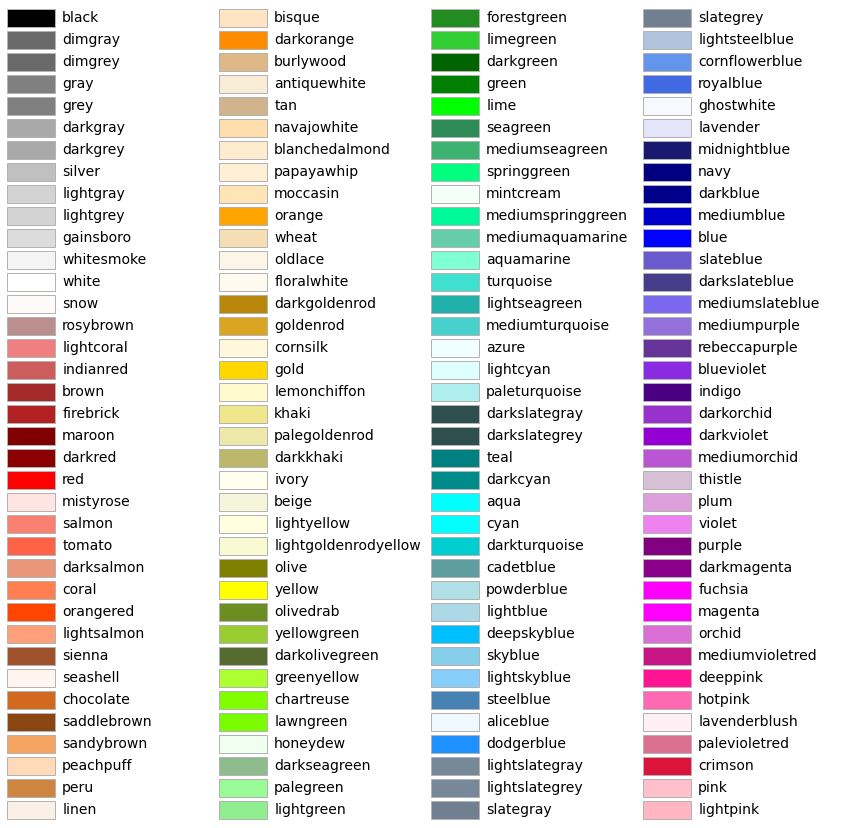

In [45]:
plot_colortable(mcolors.CSS4_COLORS)
plt.show()